# RL solutions for combinatorial games: Temporal Difference Methods

**This notebook presents the implementation with little to no explanation, all details are covered in [this notebook](nim_MC_on_policy.ipynb)**

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

In [3]:
# A Simple Nim Game
class SimpleNim:
    def __init__(self, state):
        self.heaps = state
        self.turn = 0
        self.num_heaps = len(self.heaps)

    def get_state(self):
        if isinstance(self.heaps, list):
            return tuple(self.heaps)
        else:
            return tuple(self.heaps.tolist())

    def get_num_heaps(self):
        return self.num_heaps

    def get_heap_size(self, heap_index):
        if 0 <= heap_index < self.num_heaps:
            return self.heaps[heap_index]
        return None

    def is_game_over(self):
        return all(pebbles == 0 for pebbles in self.heaps)

    def make_move(self, heap_index, num_pebbles):
        if self.is_game_over():
            return False

        # Validate the move
        if 0 <= heap_index < self.num_heaps and 0 < num_pebbles <= self.heaps[heap_index]:
            self.heaps[heap_index] -= num_pebbles
            self.turn = 1 - self.turn  # Switch turns
            return True
        return False

    def winner(self):
        if self.is_game_over():
            return 1-self.turn
        return None

In [4]:
def nim_sum(s):
    xor = 0
    for heap in s:
        xor ^= heap
    return xor

In [5]:
def play_optimal(game):
    if game.is_game_over():
        return
    heaps = game.get_state()

    nimber = nim_sum(heaps)
    largest_index, largest = max(enumerate(heaps), key=lambda x:x[1])

    if nimber != 0:
        game.make_move(largest_index, largest - (largest^nimber)) # optimal move
    else:
        game.make_move(largest_index, 1) # take the move that progresses the game to the least possible extent and hope for a blunder

In [6]:
# simple simulation of a nim game with both players using the optimal strategy
heaps = [10] * 3
game = SimpleNim(heaps)
while not game.is_game_over():
    play_optimal(game)
    print(game.get_state())
print("The winner is Player ", game.winner())

(0, 10, 10)
(0, 9, 10)
(0, 9, 9)
(0, 8, 9)
(0, 8, 8)
(0, 7, 8)
(0, 7, 7)
(0, 6, 7)
(0, 6, 6)
(0, 5, 6)
(0, 5, 5)
(0, 4, 5)
(0, 4, 4)
(0, 3, 4)
(0, 3, 3)
(0, 2, 3)
(0, 2, 2)
(0, 1, 2)
(0, 1, 1)
(0, 0, 1)
(0, 0, 0)
The winner is Player  0


## Defining State and Action Spaces:
**The State** is given by a configuration of heaps($\N_0$ means the set of naturals that includes zero):
$$ \mathcal S = \N_0^h $$
where h is the number of heaps
**Actions** are given by two tuples of heap number and number of pebbles to be taken out:
$$ \mathcal A(s) = H(s) \times \N $$ 
where $\N$ does not include zero and $H(s)$ is the set of heaps having non zero number of pebbles in the state s

In [7]:
# helper function that evaluates a policy based on whether the turn ends on a nim sum of 0
def is_optimal(s, a):
    s = list(s)
    if a[1] == 0: return False
    s[a[0]] -= a[1]
    return nim_sum(s) == 0

In [8]:
# for simplicity consider the version of the problem that starts off with same number of pebbles in each heap and 3 heaps
num_heaps = 3
initial_pebbles = 8
max_episodes = 100000

In [9]:
# Defining a class for epsilon greedy policy that has methods to update epsilon to account for GLIE conditions and to sample from epsilon greedy policy
class EpsilonGreedyPolicy:
    def __init__(self):
        self.epsilon = 1

    def update(self, epsilon):
        self.epsilon = epsilon

    def policy(self, s, Q):
        if s not in Q or np.random.random() < self.epsilon:
            index = np.random.randint(0, len(s))
            while s[index] == 0:
                index = np.random.randint(0, len(s))
            return (index, 1)
        else:
            return max(Q[s], key=Q[s].get)

    # Returns a policy that does not explore
    def final_policy(self, s, Q):
        if s not in Q or len(Q[s]) == 0:
            return (0,0)
        return max(Q[s], key=Q[s].get)

In [10]:
class SimpleGreedyPolicy:
    def update(self, epsilon): pass

    def policy(self, s, Q):
        if s not in Q:
            index = np.random.randint(0, len(s))
            while s[index] == 0:
                index = np.random.randint(0, len(s))
            return (index, 1)
        return max(Q[s], key=Q[s].get)

    def final_policy(self, s, Q):
        if s not in Q:
            return (0,0)
        return max(Q[s], key=Q[s].get)

In [11]:
def sample_step_zero_on_losing(game, A):
    game.make_move(A[0],A[1])
    play_optimal(game)
    S_next = game.get_state()
    if game.is_game_over() and game.winner() == 0: return 1, S_next
    else: return 0, S_next

### SARSA: On policy TD(0)

In [12]:
# SARSA with exploring starts
def sarsa(gamma=1, policy=EpsilonGreedyPolicy(), step_size=0.02, es=True, sample_step=sample_step_zero_on_losing, epsilon_schedule=None):
    Q = {} # take default to be zero

    if epsilon_schedule is None: policy.update(0.05)

    for i in tqdm(range(max_episodes)):
        S = np.random.randint(0, initial_pebbles+1, num_heaps)
        while all(S == 0):
            S = np.random.randint(0, initial_pebbles+1, num_heaps)
        heap_num = np.random.randint(0,num_heaps)
        while S[heap_num] == 0:
            heap_num = np.random.randint(0,num_heaps)
        game = SimpleNim(S)

        S = tuple(S.tolist())
        if es: A = (heap_num, np.random.randint(1, S[heap_num]+1)) # Exploring start
        else: A = policy.policy(S, Q)

        while not game.is_game_over():
            R, S1 = sample_step(game, A)
            if game.is_game_over():
                A1 = (0,0)
            else:
                A1 = policy.policy(S1, Q)

            if S1 not in Q:
                Q[S1] = {}
            if A1 not in Q[S1]:
                Q[S1][A1] = 0
            if S not in Q:
                Q[S] = {}
            if A not in Q[S]:
                Q[S][A] = 0
            target = R + gamma*Q[S1][A1]
            delta = target-Q[S][A]
            Q[S][A] = Q[S][A] + step_size*delta

            A = A1
            S = S1

        if epsilon_schedule is not None: policy.update(epsilon=epsilon_schedule[i])

    return policy, Q

In [13]:
# Epsilon Greedy and exploring starts
policy, Q = sarsa()

print(Q)

100%|██████████| 100000/100000 [00:02<00:00, 35031.53it/s]

{(1, 3, 2): {(2, 1): 0.13347730399294302, (2, 2): 0.013501377804628843, (0, 1): 0.017090927178770265, (1, 3): 0.04988254654499016, (1, 1): 0.6218495546570064, (1, 2): 0.0029293664183714656}, (6, 3, 7): {(0, 5): 0.03823084365994966, (2, 4): 0.0028958970071824306, (1, 1): 0.09727164126449817, (1, 2): 0.08226793230556648, (2, 6): 0.028748665287574762, (0, 3): 0.004474758408789415, (0, 1): 0.05449698855348278, (2, 5): 0.07338193958289084, (0, 2): 0.04087326947614482, (2, 1): 0.04570287201883144, (0, 6): 0.0015654166496822895, (2, 3): 0.01633297278812229, (1, 3): 0.03661246126417069, (2, 7): 0.003764242416443079, (2, 2): 0.01795122711000071, (0, 4): 0.05084731677262192}, (1, 0, 1): {(2, 1): 0.0080676569079173, (0, 1): 0.00954383694293078}, (0, 0, 0): {(0, 0): 0}, (6, 4, 2): {(0, 1): 0.622157692283005, (2, 1): 0.22458738248452936, (2, 2): 0.00923245387325797, (0, 4): 0.021162792461643758, (0, 3): 0.0914134713584906, (1, 1): 0.178227996599992, (1, 3): 0.10413950286852769, (1, 4): 0.0500300855

In [14]:
import itertools

def evaluate_on_winning_positions(policy, Q):
    fumbles = 0
    num_winning_pos = 0
    for s in itertools.product(range(initial_pebbles), repeat=num_heaps):
        if s == (0)*num_heaps: continue
        action = policy.final_policy(s, Q)
        if nim_sum(s) == 0: continue
        if not is_optimal(s, action):
            fumbles+=1
        num_winning_pos+=1
    return fumbles, num_winning_pos

In [15]:
def evaluate_using_fumbles(policy, Q):
    fumbles, num_winning_pos = evaluate_on_winning_positions(policy, Q)
    print('number of fumbles:', fumbles)
    print('total number of winning positions:', num_winning_pos)
    print('percentage of winning positions fumbled: {:.2f} %'.format(fumbles/num_winning_pos*100))

In [16]:
evaluate_using_fumbles(policy, Q)

number of fumbles: 262
total number of winning positions: 448
percentage of winning positions fumbled: 58.48 %


In [17]:
# Epsilon Greedy but no exploring starts
policy, Q = sarsa(es=False)

print(Q)

100%|██████████| 100000/100000 [00:03<00:00, 31412.12it/s]

{(5, 5, 0): {(0, 1): 0.05981371478676758, (1, 1): 0.06196320795672056}, (5, 6, 8): {(1, 1): 0.12694003412360347, (0, 1): 0.012952823703128571, (2, 1): 0.026302133750200848}, (4, 4, 0): {(0, 1): 0.06394852131992364, (1, 1): 0.05560586523390911}, (3, 3, 0): {(1, 1): 0.05333535849445394, (0, 1): 0.06966232317707804}, (2, 2, 0): {(0, 1): 0.08059178842996041, (1, 1): 0.05275713974754648}, (1, 1, 0): {(1, 1): 0.06279369518130597, (0, 1): 0.03470332652342397}, (0, 0, 0): {(0, 0): 0}, (7, 3, 1): {(2, 1): 0.11959882045019911, (0, 1): 0.007428939489440795, (1, 1): 0.022111002954094603}, (4, 1, 4): {(0, 1): 0.46091798752203306, (1, 1): 0.22642549221176803, (2, 1): 0.30670473910930807}, (5, 2, 4): {(1, 1): 0.22754131637307293, (2, 1): 0.45693721465017245, (0, 1): 0.1503415139980979}, (3, 1, 2): {(1, 1): 0.3204494412366819, (0, 1): 0.46836448646626677, (2, 1): 0.0830023712213813}, (2, 0, 2): {(2, 1): 0.3423008174091606, (0, 1): 0.3003917038018926}, (1, 0, 1): {(0, 1): 0.21385506984575026, (2, 1): 0

In [18]:
evaluate_using_fumbles(policy, Q)

number of fumbles: 382
total number of winning positions: 448
percentage of winning positions fumbled: 85.27 %


In [19]:
# Apply the new rewards model with negative rewards for losses
def sample_step_negative_on_losing(game, A):
    game.make_move(A[0],A[1])
    play_optimal(game)
    S_next = game.get_state()
    if game.is_game_over() and game.winner() == 0: return 1, S_next
    elif game.is_game_over(): return -1, S_next
    else: return 0, S_next

In [20]:
# Epsilon Greedy with exploring starts negative rewards on losing
policy, Q = sarsa(es=False, sample_step=sample_step_negative_on_losing)

print(Q)

100%|██████████| 100000/100000 [00:03<00:00, 27905.50it/s]

{(6, 1, 7): {(0, 1): 0.11241061205722083, (2, 1): 0.29485106557084406, (1, 1): -0.179246251295811}, (7, 2, 7): {(1, 1): 0.019295272654782133, (0, 1): 0.36464372943236034, (2, 1): 0.03634193956861202}, (5, 1, 4): {(2, 1): 0.4109810724460713, (0, 1): 0.1954847070312549, (1, 1): -0.6138658144056671}, (2, 1, 3): {(0, 1): -0.7421006441666842, (1, 1): -0.7647255007759407, (2, 1): 0.35003011010206225}, (1, 1, 0): {(1, 1): -0.9095552184951592, (0, 1): -0.8119701789509872}, (0, 0, 0): {(0, 0): 0}, (4, 1, 5): {(1, 1): -0.24573262377119892, (2, 1): 0.06887691015318471, (0, 1): 0.37611566208009906}, (8, 1, 5): {(0, 1): 0.29422058380033445, (1, 1): -0.03535609809667642}, (4, 0, 4): {(0, 1): -0.9213168297298915, (2, 1): -0.8654643778161241}, (3, 0, 3): {(2, 1): -0.8477395232211739, (0, 1): -0.9186997816903977}, (2, 0, 2): {(0, 1): -0.8187122898831558, (2, 1): -0.9216940063231163}, (1, 0, 1): {(2, 1): -0.8498636572162618, (0, 1): -0.956847192658036}, (0, 2, 2): {(1, 1): -0.7537016312648416, (2, 1): -

In [21]:
evaluate_using_fumbles(policy, Q)

number of fumbles: 357
total number of winning positions: 448
percentage of winning positions fumbled: 79.69 %


In [22]:
# Epsilon Greedy with exploring starts negative rewards on losing
policy, Q = sarsa(sample_step=sample_step_negative_on_losing)

print(Q)

100%|██████████| 100000/100000 [00:02<00:00, 33895.82it/s]

{(2, 0, 2): {(2, 1): -0.9714601608626808, (0, 1): -0.955856913716415, (0, 2): -0.9850368253847095, (2, 2): -0.986568923748278}, (3, 0, 7): {(0, 1): -0.3380548742814314, (2, 5): -0.2139582195173504, (2, 1): -0.10000828293563771, (2, 2): -0.1700005394256308, (0, 2): -0.378650725635842, (0, 3): -0.3842196634909215, (2, 6): -0.1571253473285719, (2, 7): -0.2762022794075042, (2, 3): -0.139805812736606, (2, 4): 0.03323067713709327}, (1, 0, 1): {(2, 1): -0.9235822541221983, (0, 1): -0.9885121458282535}, (0, 0, 0): {(0, 0): 0}, (3, 0, 4): {(0, 1): -0.5260232567453171, (2, 1): 0.24387168276013832, (2, 3): -0.30555394340783776, (0, 3): -0.304864669142967, (2, 2): -0.21458152984043796, (0, 2): -0.2754937122476288, (2, 4): -0.2762022794075042}, (4, 0, 5): {(2, 1): 0.2191655590081535, (0, 2): -0.3044968246811331, (0, 1): -0.31729255822202523, (0, 3): -0.35193133893247674, (0, 4): -0.2463580585250981, (2, 2): -0.2072773437774951, (2, 5): -0.2614308973545961, (2, 3): -0.17451828594078694, (2, 4): -0.2

In [23]:
evaluate_using_fumbles(policy, Q)

number of fumbles: 230
total number of winning positions: 448
percentage of winning positions fumbled: 51.34 %


In [24]:
# providing a way to check performance more reliably
def evaluate_using_fumbles_averaged(train, num_iters=5):
    num_winning_pos = 0
    total_fumbles = 0
    for i in range(num_iters):
        print(f'iteration {i+1}')
        policy, Q = train(sample_step=sample_step_negative_on_losing)

        fumbles, num_winning_pos = evaluate_on_winning_positions(policy, Q)
        total_fumbles += fumbles
    return total_fumbles, num_winning_pos

In [25]:
# num_iters = 5
# total_fumbles, num_winning_pos = evaluate_using_fumbles_averaged(sarsa, num_iters=num_iters)
# print('average number of fumbles: ', total_fumbles/num_iters)
# print('fumble rate: {:.2f}%'.format(total_fumbles/float(num_winning_pos*num_iters)*100))

### Q-Learning: Off-policy TD(0)

In [ ]:
# Q-Learning
def qlearning(gamma=1, policy=EpsilonGreedyPolicy(), step_size=0.02, es=True, sample_step=sample_step_zero_on_losing, epsilon_schedule=None, epsilon_schedule_update=None):
    Q = {} # take default to be zero

    if epsilon_schedule_update is None and epsilon_schedule is None: policy.update(0.05)

    for i in tqdm(range(max_episodes)):
        S = np.random.randint(0, initial_pebbles+1, num_heaps)
        while all(S == 0):
            S = np.random.randint(0, initial_pebbles+1, num_heaps)
        heap_num = np.random.randint(0,num_heaps)
        while S[heap_num] == 0:
            heap_num = np.random.randint(0,num_heaps)
        game = SimpleNim(S)

        S = tuple(S.tolist())
        if es: A = (heap_num, np.random.randint(1, S[heap_num]+1)) # Exploring start
        else: A = policy.policy(S, Q)

        while not game.is_game_over():
            R, S1 = sample_step(game, A)
            if game.is_game_over():
                A1 = (0,0)
            else:
                A1 = policy.policy(S1, Q)

            if S1 not in Q:
                Q[S1] = {}

            if len(Q[S1]) != 0: Q_max = Q[S1][max(Q[S1])]
            else: Q_max = 0

            if S not in Q:
                Q[S] = {}
            if A not in Q[S]:
                Q[S][A] = 0
            target = R + gamma*Q_max
            delta = target-Q[S][A]
            Q[S][A] = Q[S][A] + step_size*delta

            A = A1
            S = game.get_state()

        if epsilon_schedule_update is not None: epsilon_schedule_update(policy, i)
        if epsilon_schedule is not None: policy.update(epsilon_schedule[i])

    return policy, Q

In [27]:
policy, Q = qlearning(sample_step=sample_step_negative_on_losing)

print(Q)

100%|██████████| 100000/100000 [00:02<00:00, 33727.19it/s]

{(2, 2, 0): {(1, 1): -0.9442726189311119, (0, 1): -0.9133313594855829, (0, 2): -0.9929210609622838, (1, 2): -0.9882137147112451}, (2, 3, 4): {(1, 1): -0.2536823619593056, (2, 2): -0.13559591149847366, (1, 3): -0.31328073845584903, (0, 1): -0.13116106142847753, (2, 4): -0.14266744569785966, (2, 1): -0.046943422824102105, (0, 2): -0.42302559239674375, (1, 2): -0.08750532611828248, (2, 3): -0.0827338924435641}, (1, 1, 0): {(0, 1): -0.979168122200497, (1, 1): -0.9146177084345326}, (0, 0, 0): {}, (2, 4, 6): {(1, 1): -0.2533814185891316, (2, 4): -0.26804122521091284, (1, 3): -0.24864220194802228, (2, 2): -0.24774404380299436, (0, 1): -0.2494839509708299, (0, 2): -0.3157908093946184, (2, 5): -0.25633281985661727, (2, 1): -0.24870565506697395, (2, 6): -0.25350154769468275, (1, 4): -0.25483146120352035, (1, 2): -0.25388213129134957, (2, 3): -0.2504276187464193}, (7, 4, 7): {(0, 5): -0.02885179216537182, (2, 2): -0.026082260600888273, (0, 4): -0.007992175686575561, (1, 1): -0.02575972051293001, 

In [28]:
evaluate_using_fumbles(policy, Q)

number of fumbles: 167
total number of winning positions: 448
percentage of winning positions fumbled: 37.28 %


In [ ]:
def simplest_schedule(policy, i):
    policy.update(1.0/(i+1))


100%|██████████| 100000/100000 [00:02<00:00, 34971.78it/s]


In [ ]:
policy, Q = qlearning(sample_step=sample_step_negative_on_losing, epsilon_schedule_update=simplest_schedule)

In [30]:
evaluate_using_fumbles(policy, Q)

number of fumbles: 169
total number of winning positions: 448
percentage of winning positions fumbled: 37.72 %


In [31]:
def get_geometric_schedule(decay):
    epsilon_schedule = []
    for i in range(max_episodes):
        epsilon_schedule.append((1-decay)*(decay**i))
    return epsilon_schedule

In [32]:
policy, Q = qlearning(sample_step=sample_step_negative_on_losing, epsilon_schedule=get_geometric_schedule(decay=0.7))
evaluate_using_fumbles(policy, Q)

100%|██████████| 100000/100000 [00:02<00:00, 35635.64it/s]

number of fumbles: 141
total number of winning positions: 448
percentage of winning positions fumbled: 31.47 %


In [33]:
fumble_rate_by_decay = []
decays = np.linspace(0.1, 0.9, 9)

for decay in decays:
    print(f'decay: {decay}')
    num_iters = 3
    total_fumbles, num_winning_pos = evaluate_using_fumbles_averaged(qlearning, num_iters=num_iters)

    fumble_rate_by_decay.append(float(total_fumbles)/float(num_winning_pos*num_iters))

decay: 0.1
iteration 1


100%|██████████| 100000/100000 [00:02<00:00, 34124.16it/s]


iteration 2


100%|██████████| 100000/100000 [00:02<00:00, 34028.63it/s]


iteration 3


100%|██████████| 100000/100000 [00:02<00:00, 34546.13it/s]


decay: 0.2
iteration 1


100%|██████████| 100000/100000 [00:02<00:00, 35288.59it/s]


iteration 2


100%|██████████| 100000/100000 [00:02<00:00, 36844.39it/s]


iteration 3


100%|██████████| 100000/100000 [00:02<00:00, 34925.06it/s]


decay: 0.30000000000000004
iteration 1


100%|██████████| 100000/100000 [00:02<00:00, 34863.97it/s]


iteration 2


100%|██████████| 100000/100000 [00:02<00:00, 35448.33it/s]


iteration 3


100%|██████████| 100000/100000 [00:02<00:00, 35508.99it/s]


decay: 0.4
iteration 1


100%|██████████| 100000/100000 [00:02<00:00, 34833.17it/s]


iteration 2


100%|██████████| 100000/100000 [00:02<00:00, 36054.24it/s]


iteration 3


100%|██████████| 100000/100000 [00:02<00:00, 35935.38it/s]


decay: 0.5
iteration 1


100%|██████████| 100000/100000 [00:02<00:00, 36771.25it/s]


iteration 2


100%|██████████| 100000/100000 [00:02<00:00, 35830.30it/s]


iteration 3


100%|██████████| 100000/100000 [00:02<00:00, 35590.58it/s]


decay: 0.6
iteration 1


100%|██████████| 100000/100000 [00:02<00:00, 33729.21it/s]


iteration 2


100%|██████████| 100000/100000 [00:02<00:00, 35503.90it/s]


iteration 3


100%|██████████| 100000/100000 [00:02<00:00, 34588.06it/s]


decay: 0.7000000000000001
iteration 1


100%|██████████| 100000/100000 [00:02<00:00, 35121.05it/s]


iteration 2


100%|██████████| 100000/100000 [00:02<00:00, 35473.71it/s]


iteration 3


100%|██████████| 100000/100000 [00:02<00:00, 34414.11it/s]


decay: 0.8
iteration 1


100%|██████████| 100000/100000 [00:02<00:00, 35059.74it/s]


iteration 2


100%|██████████| 100000/100000 [00:02<00:00, 34603.37it/s]


iteration 3


100%|██████████| 100000/100000 [00:02<00:00, 34889.47it/s]


decay: 0.9
iteration 1


100%|██████████| 100000/100000 [00:02<00:00, 35392.71it/s]


iteration 2


100%|██████████| 100000/100000 [00:02<00:00, 35356.49it/s]


iteration 3


100%|██████████| 100000/100000 [00:02<00:00, 35694.49it/s]


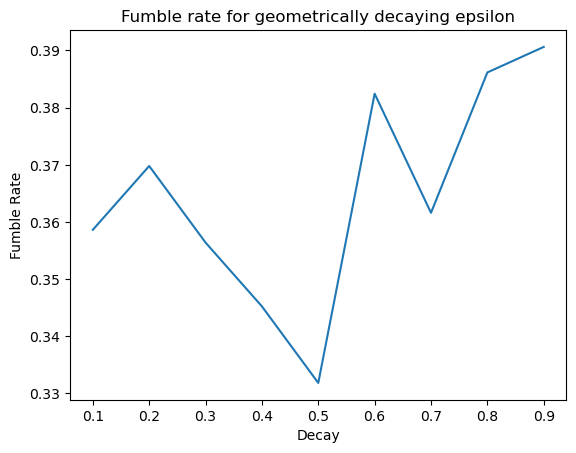

In [34]:
plt.plot(decays, fumble_rate_by_decay)
plt.xlabel('Decay')
plt.ylabel('Fumble Rate')
plt.title('Fumble rate for geometrically decaying epsilon')
plt.show()

In [36]:
policy, Q = qlearning(sample_step=sample_step_negative_on_losing, epsilon_schedule=get_geometric_schedule(decay=0.5))
evaluate_using_fumbles(policy, Q)

100%|██████████| 100000/100000 [00:02<00:00, 36558.26it/s]

number of fumbles: 153
total number of winning positions: 448
percentage of winning positions fumbled: 34.15 %


In [37]:
def default_step_size_scheduler(alpha=0.02):
    return alpha

In [71]:
# Refactored EpsilonGreedyPolicy to include a step size scheduler
class EpsilonGreedyPolicy:
    def __init__(self):
        self.epsilon = 1

    def update(self, epsilon):
        self.epsilon = epsilon

    def policy(self, s, Q):
        if np.random.random() < self.epsilon:
            index = np.random.randint(0, len(s))
            while s[index] == 0:
                index = np.random.randint(0, len(s))
            return (index, 1)
        else: return self.get_best_action(s, Q)


    def get_best_action(self, s, Q):
        largest_Q = -np.inf
        best_action = None
        for heap in range(len(s)):
            for num_pebbles in range(1, s[heap]+1):
                if Q[s][heap, num_pebbles] > largest_Q:
                    largest_Q = Q[s][heap, num_pebbles]
                    best_action = (heap, num_pebbles)
        return best_action

    # Returns a policy that does not explore
    def final_policy(self, s, Q):
        return self.get_best_action(s, Q)

In [ ]:
# Refactored QAgent class to encapsulate the Q-learning agent
class QAgent:
    def __init__(self, sample_step=sample_step_zero_on_losing, gamma=1, policy=EpsilonGreedyPolicy(), es=True, epsilon_schedule=None, step_size_scheduler=default_step_size_scheduler):
        self.sample_step=sample_step
        self.gamma = gamma
        self.policy = policy
        self.es = es
        self.epsilon_schedule = epsilon_schedule
        self.step_size_scheduler = step_size_scheduler
        self.Q = np.zeros((initial_pebbles+1,)*num_heaps + (num_heaps, initial_pebbles+1))
        self.highest_reward = 0

    def rewards_based_epsilon_schedule(self, Q_value, epsilon):
        if Q_value > self.highest_reward:
            self.highest_reward = Q_value
            return epsilon * 0.9
        return epsilon

    def update_epsilon(self, i):
        if self.epsilon_schedule is not None:
            self.policy.update(self.epsilon_schedule[i])
        else:
            self.policy.update(self.rewards_based_epsilon_schedule(self.Q.max(), self.policy.epsilon))

    def train(self, max_episodes):
        for i in tqdm(range(max_episodes)):
            S = np.random.randint(0, initial_pebbles+1, num_heaps)
            while all(S == 0):
                S = np.random.randint(0, initial_pebbles+1, num_heaps)
            heap_num = np.random.randint(0,num_heaps)
            while S[heap_num] == 0:
                heap_num = np.random.randint(0,num_heaps)
            game = SimpleNim(S)

            S = tuple(S.tolist())
            if self.es: A = (heap_num, np.random.randint(1, S[heap_num]+1)) # Exploring start
            else: A = self.policy.policy(S, self.Q)

            while not game.is_game_over():
                R, S1 = self.sample_step(game, A)
                if game.is_game_over():
                    A1 = (0,0)
                else:
                    A1 = self.policy.policy(S1, self.Q)

                Q_max = np.max(self.Q[S1])

                target = R + self.gamma * Q_max
                delta = target - self.Q[S][A]
                step_size = self.step_size_scheduler()
                self.Q[S][A] += step_size * delta

                A = A1
                S = S1

            if self.epsilon_schedule is not None or self.policy.epsilon > 0:
                self.update_epsilon(i)

        return self.policy, self.Q

In [81]:
agent = QAgent(sample_step=sample_step_negative_on_losing, policy=EpsilonGreedyPolicy(), es=True)
policy, Q = agent.train(max_episodes)

100%|██████████| 100000/100000 [00:03<00:00, 26154.07it/s]


In [82]:
evaluate_using_fumbles(policy, Q)

number of fumbles: 244
total number of winning positions: 448
percentage of winning positions fumbled: 54.46 %
